In [85]:
import copy
import csv
import datetime
import math
import os

from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

from IPython import display

# Load Data

In [3]:
"""Steps to download the data locally
1) Download the `Logs` folder from Google Drive: https://drive.google.com/drive/folders/17qVeGr-oWAaon876jT_5HkJuAzBU8p-f
2) Unzip it, and move it into Assets/Logs in FlatWorld
"""

files = os.listdir("../Logs")
files.sort()
for file in files:
    if file.endswith(".csv"):
        with open('../Logs/' + file) as f:
            reader = csv.reader(f)
            first_line = next(reader)
            for row in reader:
                last_line = row
            start_time = datetime.datetime.strptime(first_line[0], "%m/%d/%Y %H:%M:%S.%f")
            end_time = datetime.datetime.strptime(last_line[0], "%m/%d/%Y %H:%M:%S.%f")
            print(file, str(end_time - start_time), start_time, end_time)


hand_log1542048814863.csv 0:01:04.768000 2018-11-12 10:53:34.890000 2018-11-12 10:54:39.658000
hand_log1542048995151.csv 0:00:20.730000 2018-11-12 10:56:35.181000 2018-11-12 10:56:55.911000
hand_log1542049250286.csv 0:02:07.365000 2018-11-12 11:00:50.321000 2018-11-12 11:02:57.686000
hand_log1542049392458.csv 0:02:06.582000 2018-11-12 11:03:12.496000 2018-11-12 11:05:19.078000
hand_log1542049530393.csv 0:02:40.014000 2018-11-12 11:05:30.433000 2018-11-12 11:08:10.447000
hand_log1542049693653.csv 0:02:02.406000 2018-11-12 11:08:13.696000 2018-11-12 11:10:16.102000
hand_log1542049895342.csv 0:00:25.061000 2018-11-12 11:11:35.385000 2018-11-12 11:12:00.446000
hand_log1542050067354.csv 0:00:20.589000 2018-11-12 11:14:27.396000 2018-11-12 11:14:47.985000
hand_log1542050109195.csv 0:00:36.023000 2018-11-12 11:15:09.235000 2018-11-12 11:15:45.258000
hand_log1542050233041.csv 0:00:32.603000 2018-11-12 11:17:13.084000 2018-11-12 11:17:45.687000
hand_log1542050419916.csv 0:01:36.479000 2018-11-1

In [4]:
# p1-p3 identified from screencapture timestamps: https://drive.google.com/drive/folders/1w1Wd1uBGsqCdc-RZVZTJ3oocitcwuBaS
p1_file = '../Logs/hand_log1542067070161.csv' # 16:01
p2_file = '../Logs/hand_log1542068380157.csv' # 16:27
p3_file = '../Logs/hand_log1542072558972.csv' # 17:35
p4_file = '../Logs/hand_log1542136320496.csv'
p5_file = '../Logs/hand_log1542145644623.csv'
files = [p1_file, p2_file, p3_file, p4_file, p5_file]

In [5]:
for file in files:
    event_counts = defaultdict(int)
    with open(file) as f:
        reader = csv.reader(f)
        for row in reader:
            event_counts[row[1]] += 1
    print(event_counts)

defaultdict(<class 'int'>, {'hand_6dof': 231656, 'object_6dof': 115761, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 237156, 'object_6dof': 118515, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 226008, 'object_6dof': 112941, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 164680, 'object_6dof': 82276, 'experiment_changed': 22})
defaultdict(<class 'int'>, {'hand_6dof': 355954, 'object_6dof': 177839, 'experiment_changed': 79})


# Util stuff

In [47]:
def parse_time(s):
    return datetime.datetime.strptime(s, "%m/%d/%Y %H:%M:%S.%f")

def new_events_entry(start_time):
    return {'start_time': start_time, 'object_events': []}

def parse_event(event):
    return {
        'time': parse_time(event[0]),
        'type': event[1],
        'x': float(event[2]),
        'y': float(event[3]),
        'z': float(event[4]),
        'rx': float(event[5]),
        'ry': float(event[6]),
        'rz': float(event[7]),
    }

# Participant -> [start_time, end_time, [hand_events], [object_events]]
def group_data(file):
    with open(file) as f:
        reader = csv.reader(f)
        events = [new_events_entry(None)]
        for row in reader:
            if not events[0]['start_time']:
                events[0]['start_time'] = parse_time(row[0]) 
            if row[1] == 'experiment_changed':
                events[-1]['end_time'] = parse_time(row[0])
                events.append(new_events_entry(parse_time(row[0])))
                # Add event data
#             elif row[1] == 'hand_6dof':
#                 events[-1]['hand_events'].append(parse_event(row))
            elif row[1] == 'object_6dof':
                events[-1]['object_events'].append(parse_event(row))
        events[-1][end_time] = parse_time(row[0])
    return events

p1_data = group_data(p1_file)
print(len(p1_data))

# TODO: Do something to map correctly (by hand?) to experiment conditions.

23


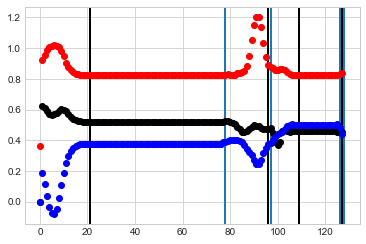

In [48]:
# Let's make sure the y axis is what we expect
# Let's also try and detect the start and end of the object moving.

def approx_eq(a, b):
    return abs(a-b) < .001

xs = []
ys = []
zs = []
for i, event in enumerate(p1_data[6]['object_events']):
    if i%10 == 0:
        xs.append(event['x'])
        ys.append(event['y'])
        zs.append(event['z'])
    
    if len(xs) > 3:
        if not approx_eq(xs[-1], xs[-2]) and approx_eq(xs[-2], xs[-3]):
            plt.axvline(x=len(xs))
        if approx_eq(xs[-1], xs[-2]) and not approx_eq(xs[-2], xs[-3]):
            plt.axvline(x=len(xs), color='black')


plt.plot(range(len(xs)), xs, 'o', color='black') 
plt.plot(range(len(xs)), ys, 'o', color='red') # Confirmed as vertical direction!
plt.plot(range(len(xs)), zs, 'o', color='blue')



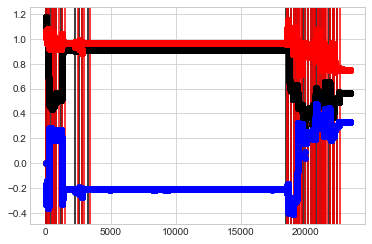

0 : [(0, 1), (4, 205), (211, 280), (296, 497), (498, 593), (595, 612), (613, 814), (817, 1018), (1205, 1236), (1257, 1458), (2270, 2471), (2559, 2760), (2781, 2982), (3243, 3444), (18492, 18592), (18609, 18639), (18653, 18854), (18857, 19058), (19060, 19168), (19171, 19299), (19301, 19380), (19384, 19455), (19458, 19659), (19681, 19741), (19753, 19954), (19956, 20157), (20166, 20367), (20375, 20576), (20578, 20669), (20675, 20739), (20757, 20911), (20912, 20942), (20947, 21056), (21073, 21274), (21280, 21356), (21357, 21427), (21433, 21458), (21461, 21662), (21784, 21847), (21856, 22057), (22058, 22195), (22206, 22407), (22411, 22612)]
0
0


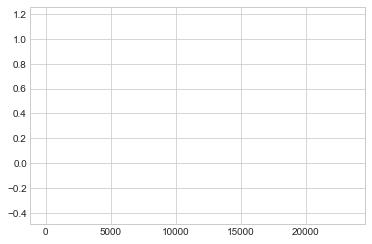

0


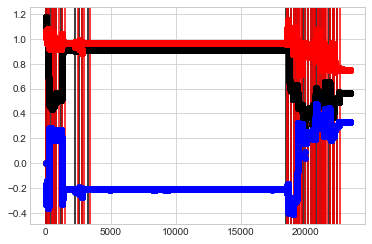

0 : [(0, 1), (4, 205), (211, 280), (296, 497), (498, 593), (595, 612), (613, 814), (817, 1018), (1205, 1236), (1257, 1458), (2270, 2471), (2559, 2760), (2781, 2982), (3243, 3444), (18492, 18592), (18609, 18639), (18653, 18854), (18857, 19058), (19060, 19168), (19171, 19299), (19301, 19380), (19384, 19455), (19458, 19659), (19681, 19741), (19753, 19954), (19956, 20157), (20166, 20367), (20375, 20576), (20578, 20669), (20675, 20739), (20757, 20911), (20912, 20942), (20947, 21056), (21073, 21274), (21280, 21356), (21357, 21427), (21433, 21458), (21461, 21662), (21784, 21847), (21856, 22057), (22058, 22195), (22206, 22407), (22411, 22612)]
0
0


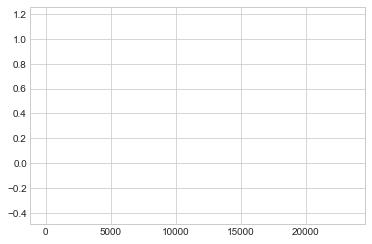

0


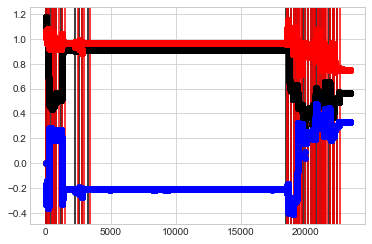

0 : [(0, 1), (4, 205), (211, 280), (296, 497), (498, 593), (595, 612), (613, 814), (817, 1018), (1205, 1236), (1257, 1458), (2270, 2471), (2559, 2760), (2781, 2982), (3243, 3444), (18492, 18592), (18609, 18639), (18653, 18854), (18857, 19058), (19060, 19168), (19171, 19299), (19301, 19380), (19384, 19455), (19458, 19659), (19681, 19741), (19753, 19954), (19956, 20157), (20166, 20367), (20375, 20576), (20578, 20669), (20675, 20739), (20757, 20911), (20912, 20942), (20947, 21056), (21073, 21274), (21280, 21356), (21357, 21427), (21433, 21458), (21461, 21662), (21784, 21847), (21856, 22057), (22058, 22195), (22206, 22407), (22411, 22612)]
0
0


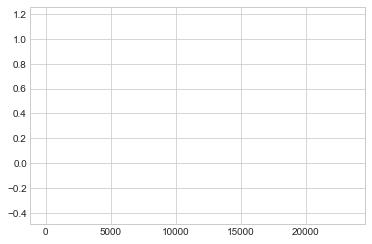

y


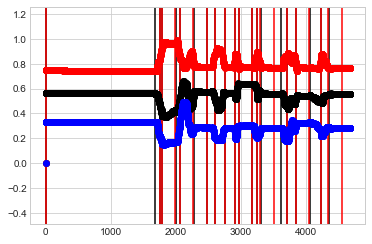

1 : [(0, 1), (1673, 1755), (1756, 1780), (1788, 1989), (1995, 2057), (2060, 2261), (2275, 2476), (2482, 2602), (2603, 2747), (2749, 2907), (2910, 2965), (2968, 3169), (3170, 3238), (3242, 3296), (3300, 3501), (3618, 3707), (3712, 3848), (3849, 4050), (4052, 4229), (4230, 4341), (4344, 4545)]
0
0


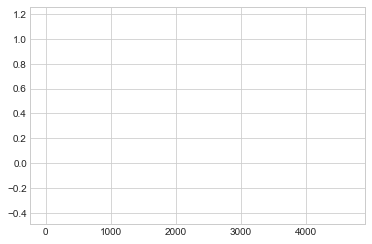

y


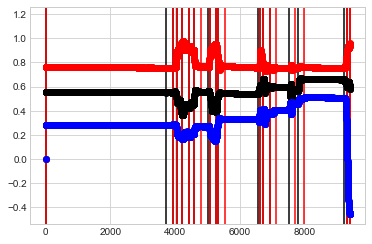

2 : [(0, 1), (3722, 3923), (3934, 4050), (4051, 4214), (4216, 4417), (4418, 4598), (4599, 4800), (5014, 5071), (5074, 5275), (5277, 5325), (5328, 5529), (6556, 6627), (6631, 6724), (6725, 6926), (6927, 7128), (7510, 7711), (7786, 7987), (9212, 9304), (9306, 9407), (9408, 9410)]
0
0


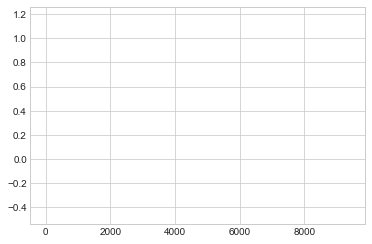

y


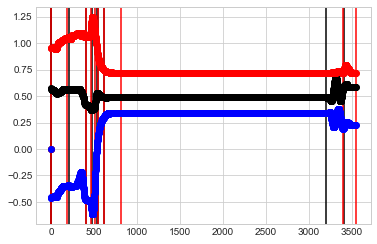

3 : [(0, 1), (3, 188), (204, 405), (409, 466), (473, 506), (530, 547), (550, 610), (611, 812), (3201, 3402), (3404, 3543)]
0
0


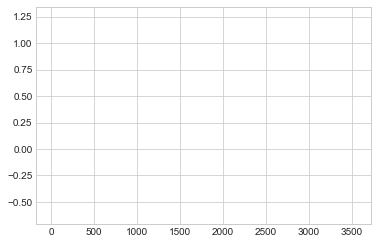

y


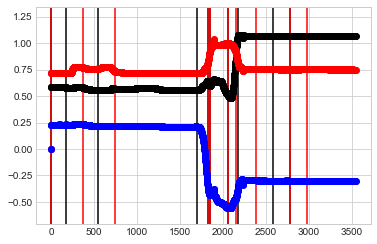

4 : [(0, 1), (171, 372), (539, 740), (1696, 1823), (1826, 1848), (1853, 2054), (2058, 2151), (2178, 2379), (2578, 2779), (2780, 2981)]
0
0


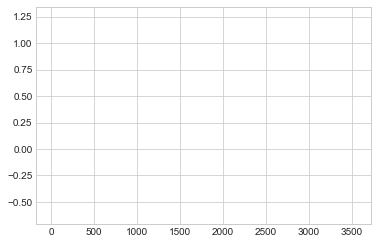

y


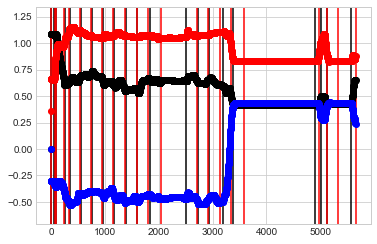

5 : [(0, 0), (44, 71), (72, 86), (87, 241), (257, 339), (343, 544), (545, 746), (752, 953), (954, 1155), (1176, 1377), (1390, 1591), (1601, 1802), (1843, 2044), (2512, 2713), (2719, 2920), (2931, 3132), (3192, 3335), (3372, 3573), (4904, 4983), (5005, 5115), (5122, 5323), (5571, 5654)]
0
0


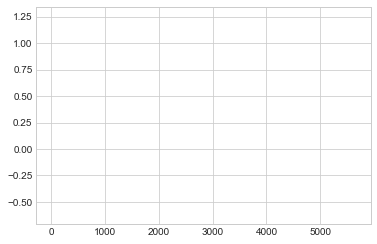

y


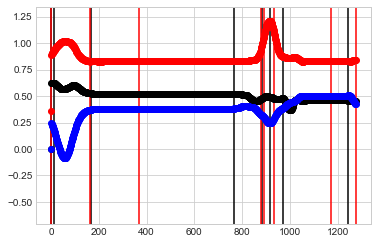

6 : [(0, 0), (11, 163), (165, 366), (765, 877), (882, 892), (918, 934), (971, 1172), (1243, 1275)]
0
0


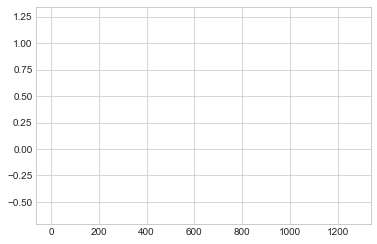

y


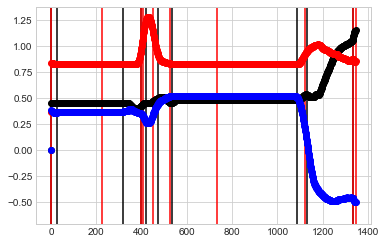

7 : [(0, 0), (25, 226), (319, 395), (397, 404), (417, 451), (470, 527), (532, 733), (1085, 1123), (1131, 1332), (1334, 1345)]
0
0


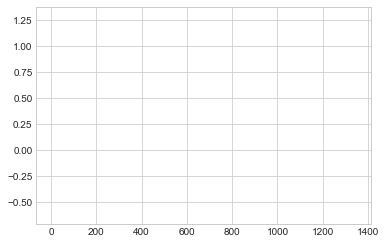

y


In [ ]:
def is_moving(xs, ys, zs):
    return ((not almost_eq(xs[-1], xs[-2]) and almost_eq(xs[-2], xs[-3])) or
        (not almost_eq(ys[-1], ys[-2]) and almost_eq(ys[-2], ys[-3])) or
        (not almost_eq(zs[-1], zs[-2]) and almost_eq(zs[-2], zs[-3]))
        )

def almost_eq(a, b):
    return abs(a-b) < .001

def trim_events_to_trial(data):
    trimmed_data = copy.deepcopy(data)
    for trial_num, trial in enumerate(trimmed_data):
        xs = []
        ys = []
        zs = []
        # Keep track of the relevant ranges
        ranges = []
        start_v_lines = [0]
        end_v_lines = []
        curr_range_start = 0
        start_y = 0

        for i, event in enumerate(trial['object_events']):
            xs.append(float(event['x']))
            ys.append(float(event['y']))
            zs.append(float(event['z']))
            if curr_range_start is not None:
                if abs(ys[-1] - start_y) >= .1 or i - curr_range_start > 200:
                    ranges.append((curr_range_start, i))
                    curr_range_start = None
                    end_v_lines.append(i)
            else:
                if len(xs) >= 3 and is_moving(xs[-3:], ys[-3:], zs[-3:]):
                    curr_range_start = i
                    start_v_lines.append(i)
                    start_y = ys[-1]
        if curr_range_start:
            ranges.append((curr_range_start, i))
            end_v_lines.append(i)

        valid = 'n'
        while valid != 'y':
            for i in start_v_lines:
                plt.axvline(x=i, color='black')
            for i in end_v_lines:
                plt.axvline(x=i, color='red')
            
            plt.plot(range(len(xs)), xs, 'o', color='black') 
            plt.plot(range(len(xs)), ys, 'o', color='red') # Confirmed as vertical direction!
            plt.plot(range(len(xs)), zs, 'o', color='blue')
            display.display(plt.gcf())

            print(trial_num, ':', ranges)
            start = int(input())
            end = int(input())

            plt.cla()

            plt.plot(range(end-start), xs[start:end], 'o', color='black') 
            plt.plot(range(end-start), ys[start:end], 'o', color='red') # Confirmed as vertical direction!
            plt.plot(range(end-start), zs[start:end], 'o', color='blue')
            display.display(plt.gcf())

            valid = input()

            trial['object_events'] = trial['object_events'][start:end]

            plt.cla()
        event['start_i'] = start
        event['end_i'] = end
    
    return trimmed_data

trim_events_to_trial(p1_data)

# def custom_trim(trimmed_data, trial_i, start_i, end_i):
#     copy_data = copy.deep_copy(trimmed_data)
#     copy_data[trial_i]['object_events'] = copy_data[trial_i]['object_events'][start_i:end_i]
#     copy_data[trial_i] = trim_events_to_trial([copy_data[trial_i]])[0]
#     return copy_data
    
# test = trim_events_to_trial([p1_data[22][]])

In [ ]:
for i, e in enumerate(trimmed_p1_data):
    print(e['start_i'], e['end_i'])

### One-off trims

In [97]:
# Metadata will be of the form:
# (hand_rep, object_type, object_rep, start_i)

# P1_METADATA = {
#     5: ('', '', '', 12, 50),
#     6: ('', '', '', 12, 50),
#     7: ('', '', '', 12, 50),
#     8: ('', '', '', 12, 50),
#     9: ('', '', '', 12, 50),
#     10: ('', '', '', 12, 50),
#     11: ('', '', '', 12, 50),
#     12: ('', '', '', 12, 50),
#     13: ('', '', '', 12, 50),
#     14: ('', '', '', 12, 50),
#     15: ('', '', '', 12, 50),
#     16: ('', '', '', 12, 50),
#     17: ('', '', '', 12, 50),
#     18: ('', '', '', 12, 50),
#     5: ('', '', '', 12, 50),
#     5: ('', '', '', 12, 50),
#     5: ('', '', '', 12, 50),
#     5: ('', '', '', 12, 50),
# }

for i, e in enumerate(trimmed_p1_data):
    print(i, e['object_events'][0]['time'])

0 2018-11-12 15:57:51.209000
1 2018-11-12 16:02:24.201000
2 2018-11-12 16:03:16.493000
3 2018-11-12 16:05:01.632000
4 2018-11-12 16:05:41.225000
5 2018-11-12 16:07:15.560000
6 2018-11-12 16:07:32.504000
7 2018-11-12 16:07:41.785000
8 2018-11-12 16:08:10.043000
9 2018-11-12 16:08:21.469000
10 2018-11-12 16:08:32.786000
11 2018-11-12 16:09:01.567000
12 2018-11-12 16:09:11.698000
13 2018-11-12 16:09:18.891000
14 2018-11-12 16:09:37.308000
15 2018-11-12 16:09:46.100000
16 2018-11-12 16:09:53.795000
17 2018-11-12 16:10:10.237000
18 2018-11-12 16:10:18.403000
19 2018-11-12 16:10:26.165000
20 2018-11-12 16:10:45.095000
21 2018-11-12 16:10:55.754000
22 2018-11-12 16:10:59.538000


# Distance Offset

0 29.04858678562306
1 0
2 0
3 0
4 0
5 4.238308102449601
6 6.307645632411668
7 2.937985825159166
8 10.96985944185649
9 44.13346743420214
10 18.615363266509746
11 10.073221456096976
12 1.5711192843261848
13 13.150456829725714
14 20.813383199781974
15 2.0441318602185388
16 6.796405759163759
17 8.030866696640919
18 8.425126386149469
19 2.3793945197028603
20 24.031630231979
21 5.425590592643278
22 0
[4.238308102449601, 6.307645632411668, 2.937985825159166, 10.96985944185649, 44.13346743420214, 18.615363266509746, 10.073221456096976, 1.5711192843261848, 13.150456829725714, 20.813383199781974, 2.0441318602185388, 6.796405759163759, 8.030866696640919, 8.425126386149469, 2.3793945197028603, 24.031630231979, 5.425590592643278]


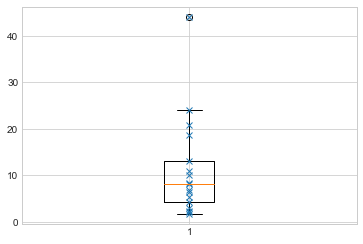

In [92]:
def dist(events):
    last_event = None
    total_dist = 0
    for e in events:
        if last_event:
            total_dist += math.sqrt((event['x'] - last_event['x'])**2 + (event['x'] - last_event['x'])**2)
        last_event = e
    return total_dist

for i, e in enumerate(trimmed_p1_data):
    print(i, dist(e['object_events']))

vals = []
for e in trimmed_p1_data[5:22]:
    vals.append(dist(e['object_events']))

print(vals)
    
plt.boxplot(vals)
plt.plot([1] * len(vals), vals, 'x')

# Rotation Offset